In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import glob
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import pandas as pd
import re
import yaml
# import imageio
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
# plt.rc('fontname', "Times New Roman")
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'



In [84]:
data_dir = "../../Xplane-data-dir/xplane-asl-test/taxinet-03-06-23/"
save_dir = "videos/"
file_name = "labels.csv"


In [85]:
with open("../params/simulator_params.yaml") as file:
	simulator_params = yaml.load(file, Loader=yaml.FullLoader)

In [86]:
df = pd.read_csv(data_dir + file_name)

def absolute_to_local_time(time_in_seconds):
    time = pd.to_datetime(time_in_seconds- 8 * 3600, unit="s")
    return time.hour + time.minute/60

def extract_episode_details(filename):
    """thank you chatGPT"""
    match = re.search(r'(\d+)_(\d+).png', filename)
    if match:
        episode_number = int(match.group(1))
        timestamp = int(match.group(2))
        return (episode_number, timestamp)
    else:
        raise ValueError(f"Could not extract episode number and timestamp from {filename}")

In [92]:
df.loc[:5,:]

image_filename  absolute_time_GMT_seconds  \
0  MWH_Runway04_afternoon_overcast_0_0.png               72081.460938   
1  MWH_Runway04_afternoon_overcast_0_1.png               72082.570312   
2  MWH_Runway04_afternoon_overcast_0_2.png               72083.664062   
3  MWH_Runway04_afternoon_overcast_0_3.png               72084.796875   
4  MWH_Runway04_afternoon_overcast_0_4.png               72085.890625   
5  MWH_Runway04_afternoon_overcast_0_5.png               72086.976562   

   relative_time_seconds  distance_to_centerline_meters  \
0               0.000000                       0.008174   
1               1.109375                       0.225767   
2               2.203125                       1.295579   
3               3.335938                       3.789829   
4               4.429688                       7.624166   
5               5.515625                      12.234952   

   distance_to_centerline_NORMALIZED  downtrack_position_meters  \
0                           0.000817                  15.538416   
1                           0.022577                  21.392167   
2                           0.129558                  27.398356   
3                           0.378983                  33.530107   
4                           0.762417                  40.347130   
5                           1.223495                  48.507507   

   downtrack_position_NORMALIZED  heading_error_degrees  \
0                       0.521074               0.001510   
1                       0.717376               4.368919   
2                       0.918791              16.575893   
3                       1.124417              27.917833   
4                       1.353022              28.991803   
5                       1.626677              30.053769   

   heading_error_NORMALIZED  speed_meters_per_second  period_of_day  \
0                  0.000050                 5.118617              1   
1                  0.145631                 5.453841              1   
2                  0.552530                 5.661218              1   
3                  0.930594                 6.327249              1   
4                  0.966393                 7.903732              1   
5                  1.001792                 9.195395              1   

   cloud_type  image_corruption  
0           4                 5  
1           4                 5  
2           4                 5  
3           4                 5  
4           4                 5  
5           4                 5

In [88]:
episodes = {}
for i, filename in enumerate(df.loc[:,"image_filename"]):
    episode, timestep = extract_episode_details(filename)
    if not episode in episodes:
        episodes[episode] = [i]
    else:
        episodes[episode].append(i)

In [89]:
len(episodes)

1

In [90]:
episode_num = 0

/tmp/ipykernel_166900/2441693775.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(3,4))


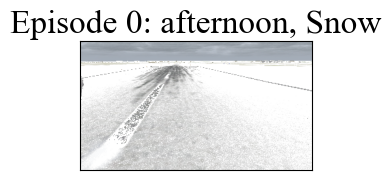

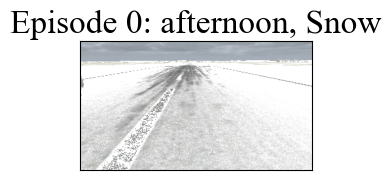

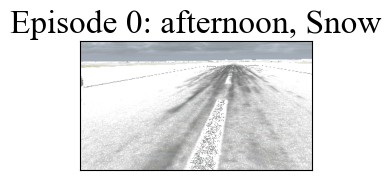

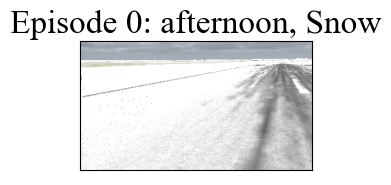

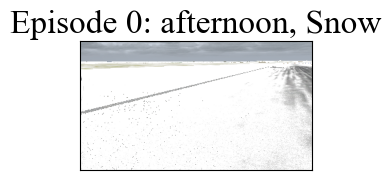

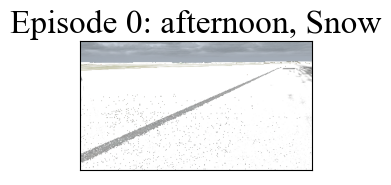

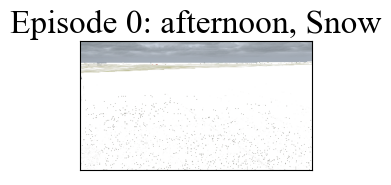

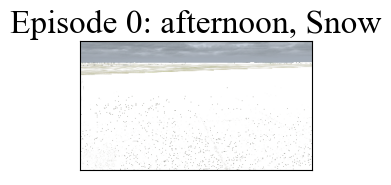

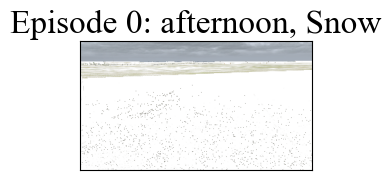

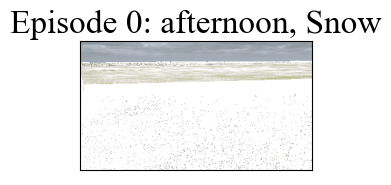

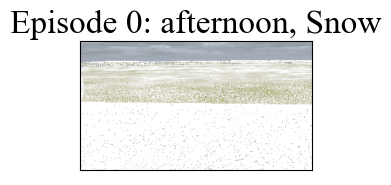

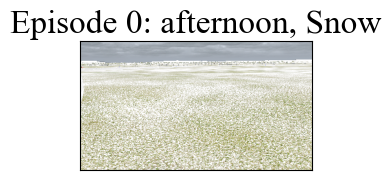

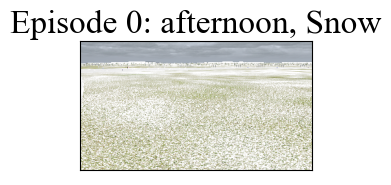

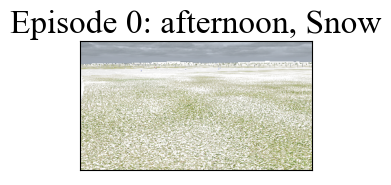

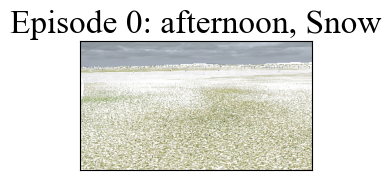

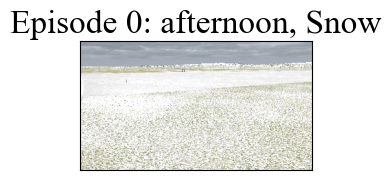

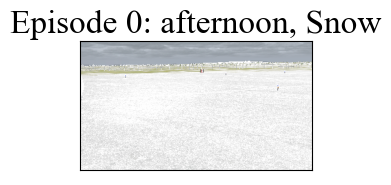

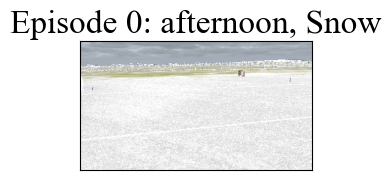

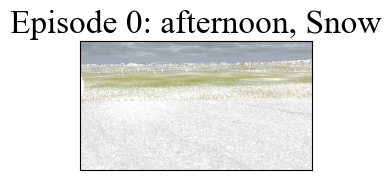

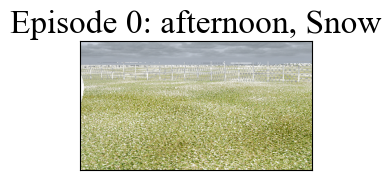

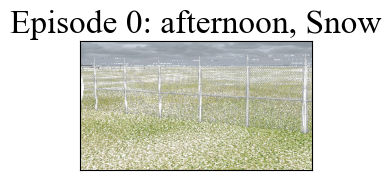

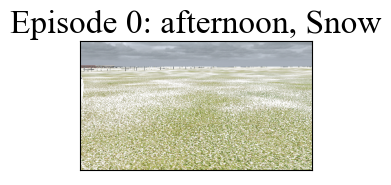

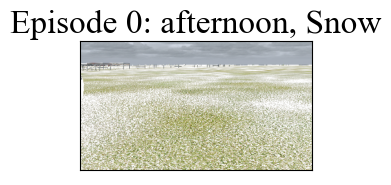

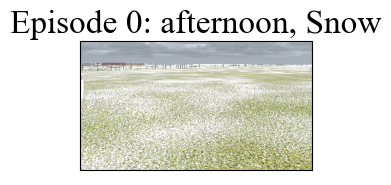

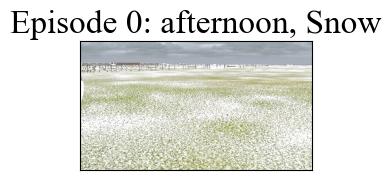

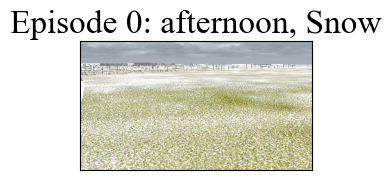

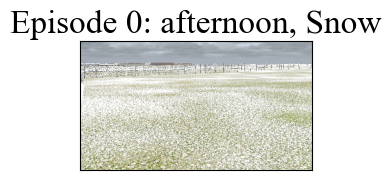

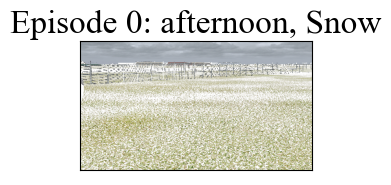

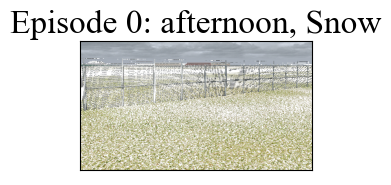

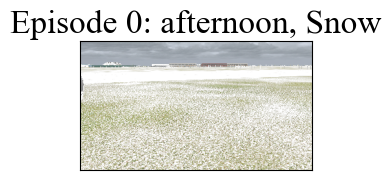

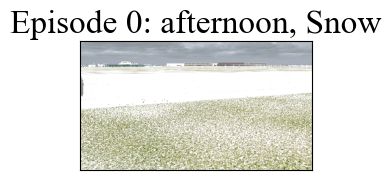

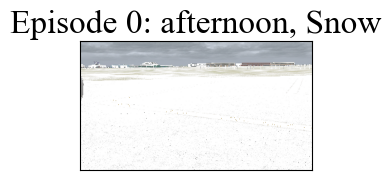

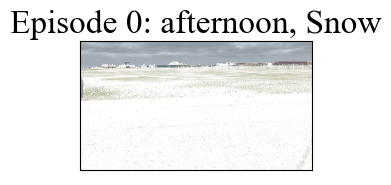

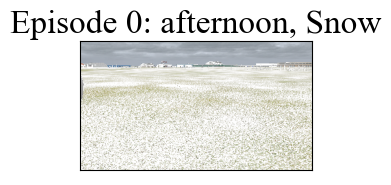

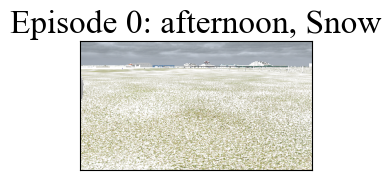

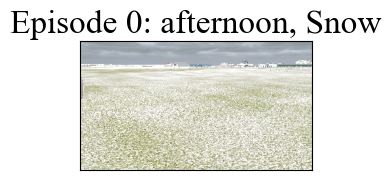

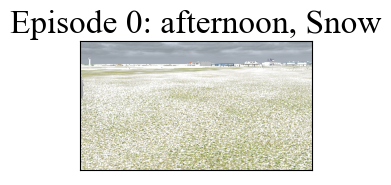

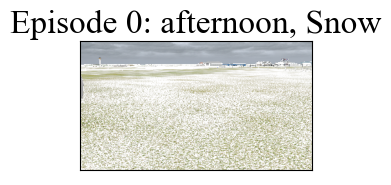

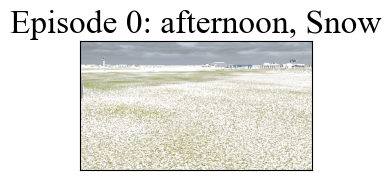

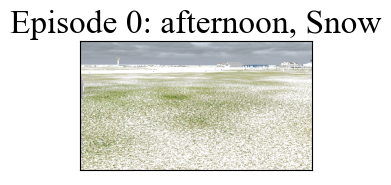

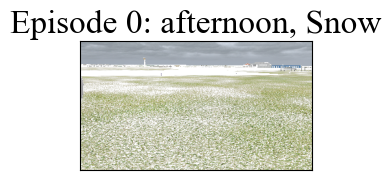

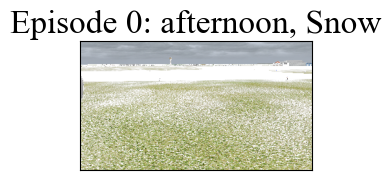

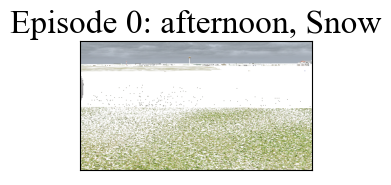

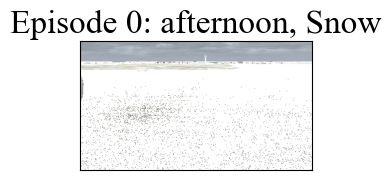

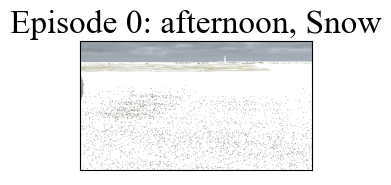

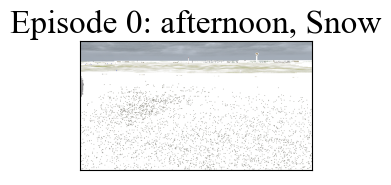

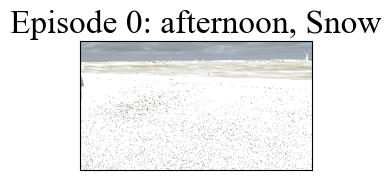

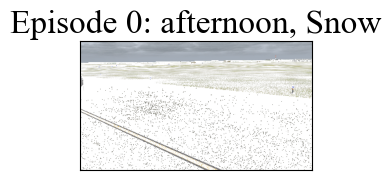

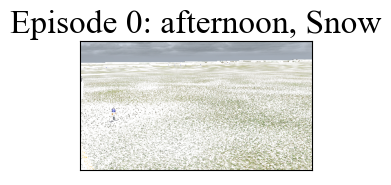

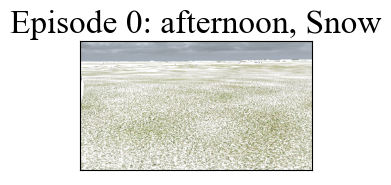

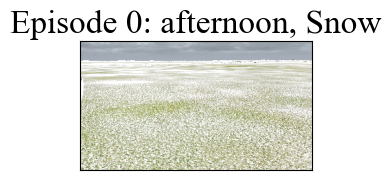

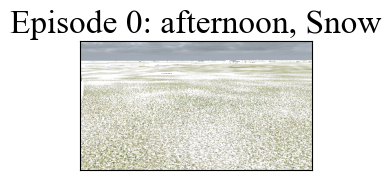

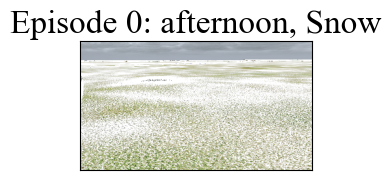

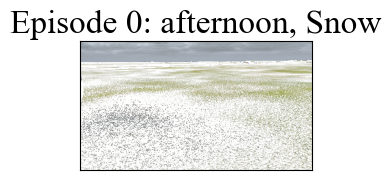

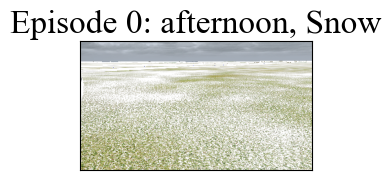

In [97]:
for i in episodes[episode_num]:
    plt.figure()
    ax = plt.gca()
    ax.imshow(img.imread(data_dir + df.loc[i, "image_filename"]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    time_of_day = simulator_params["simulator"]["time_of_day"][df.loc[i,"period_of_day"]]["label"]
    corruption = simulator_params["screenshot_camera"]["corruption_types"][df.loc[i,"image_corruption"]]
    ax.set_title("Episode %d: " % episode_num + time_of_day+ ", " + corruption)

/tmp/ipykernel_166900/3077670163.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,3))


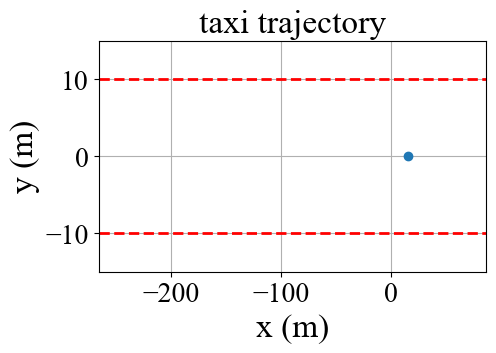

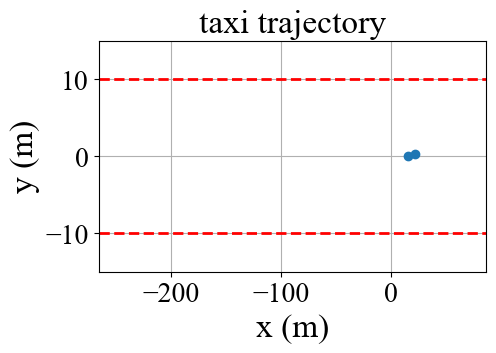

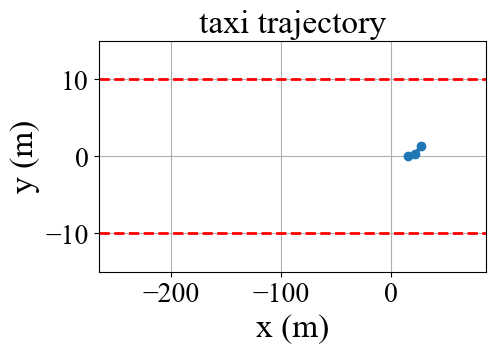

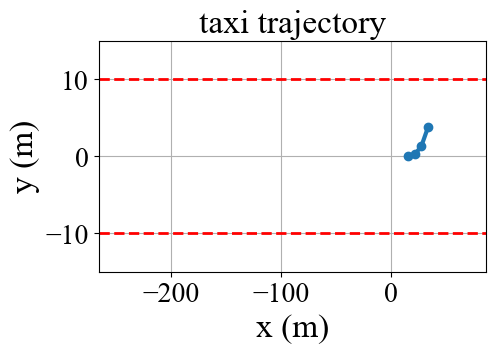

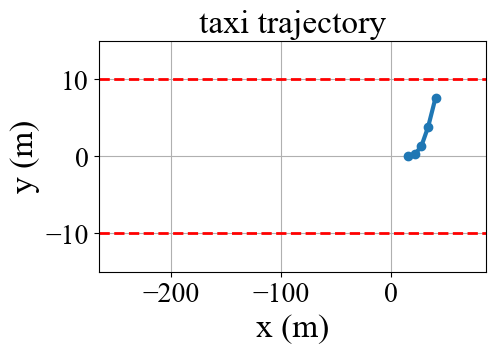

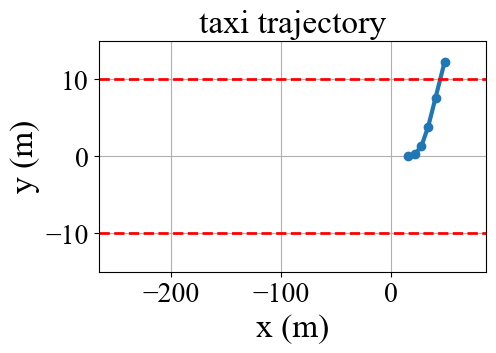

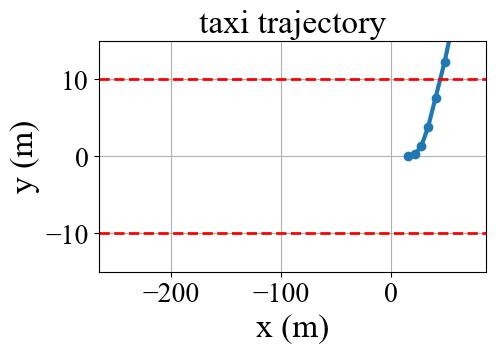

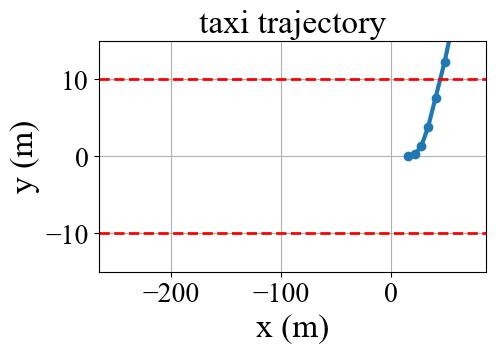

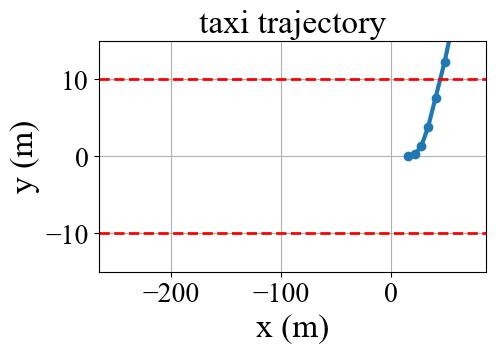

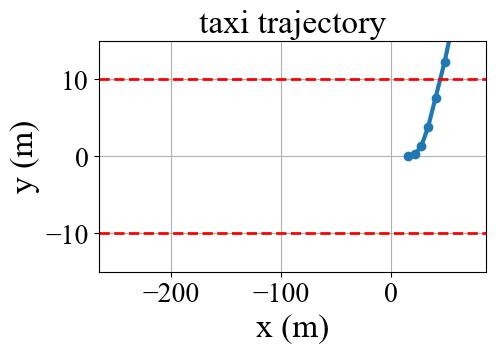

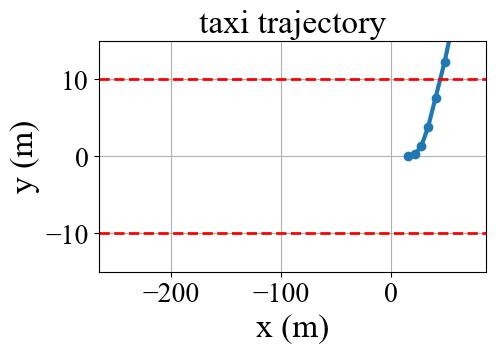

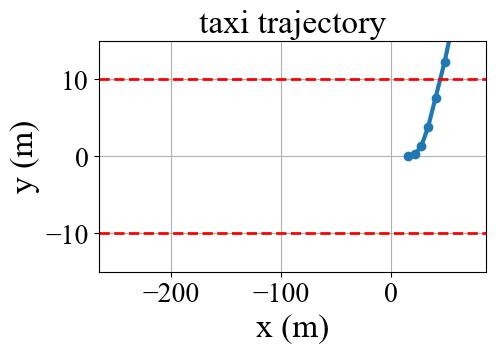

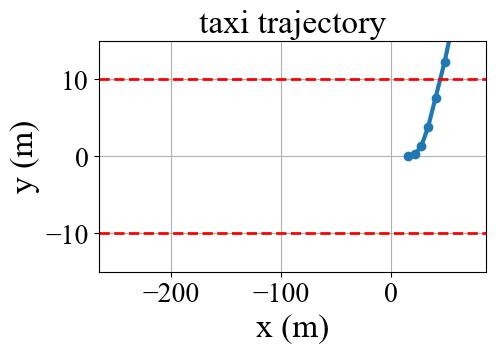

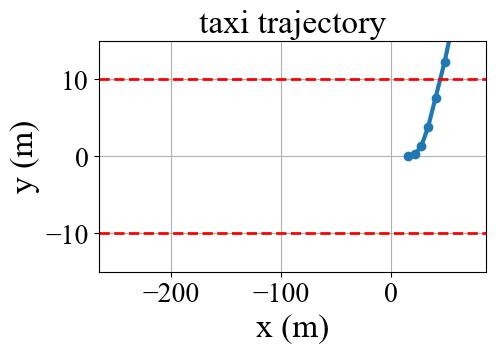

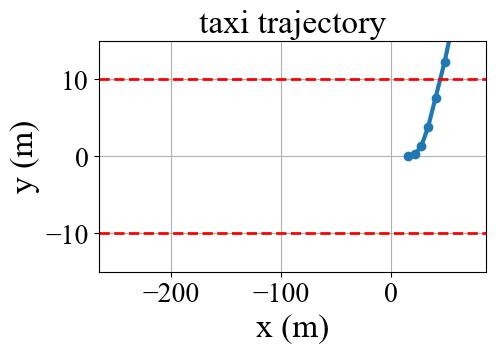

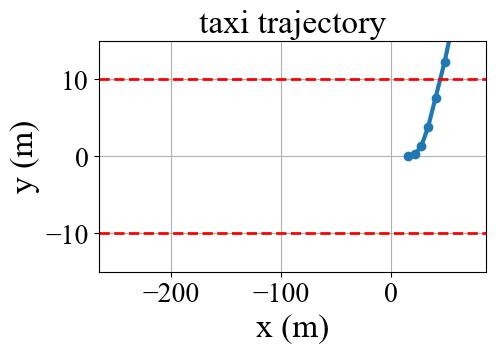

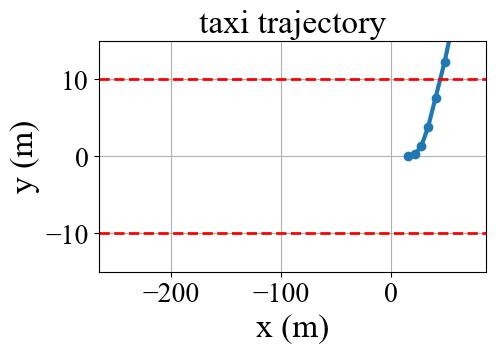

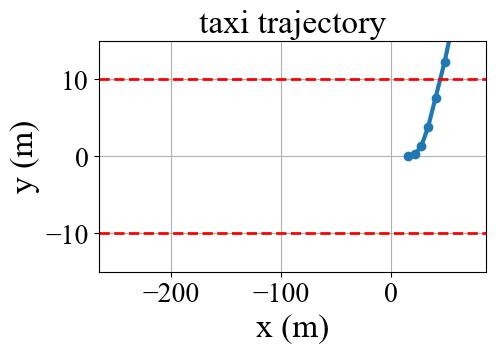

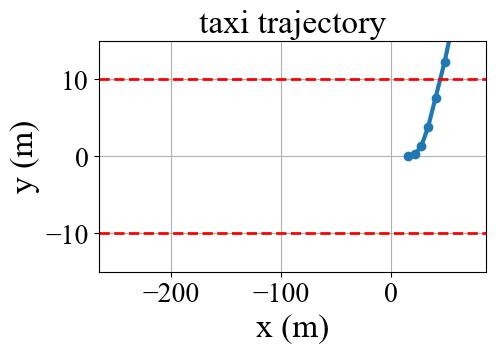

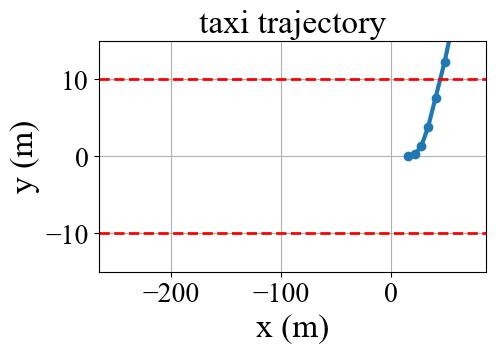

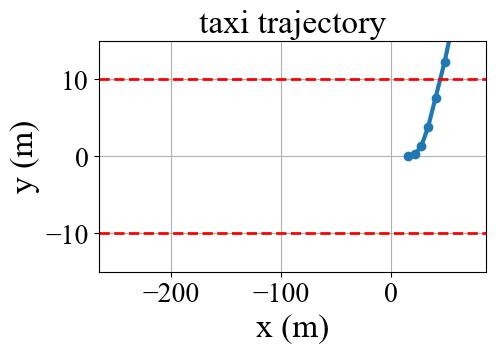

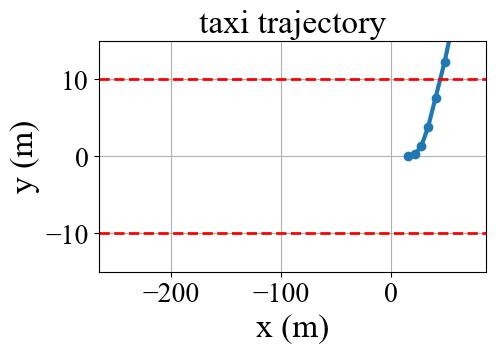

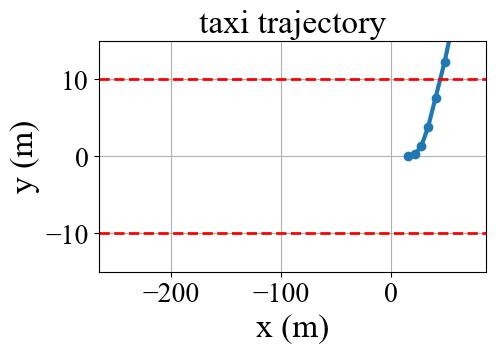

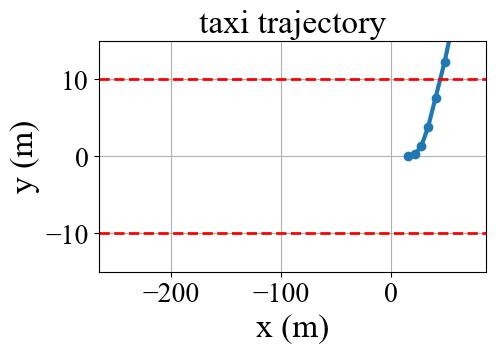

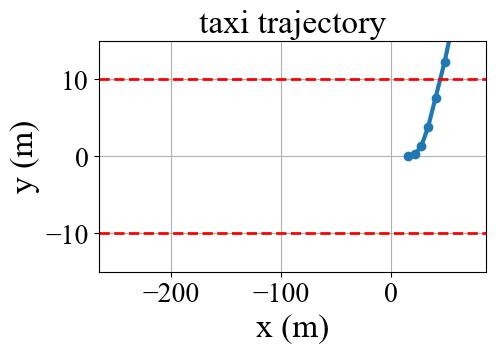

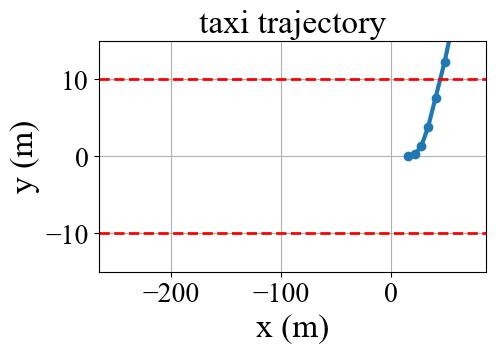

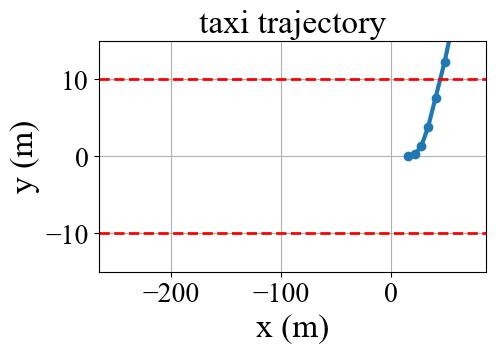

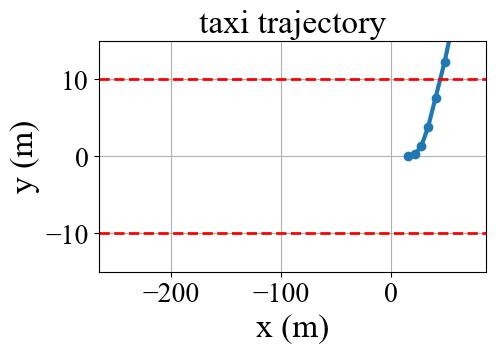

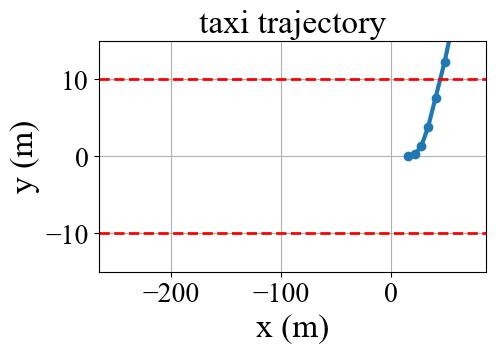

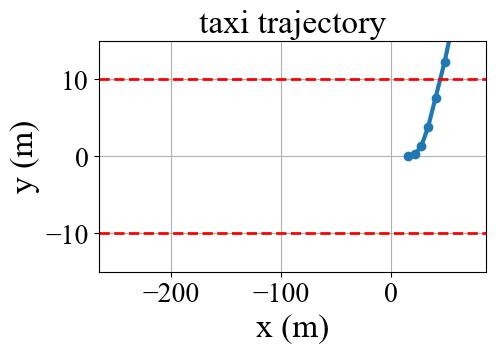

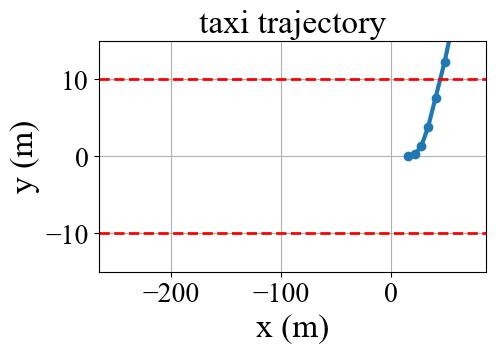

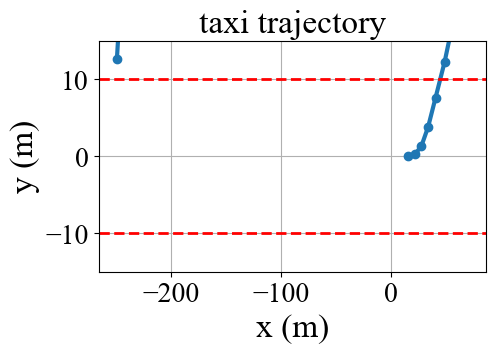

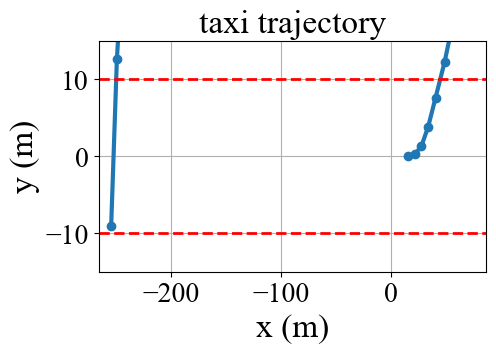

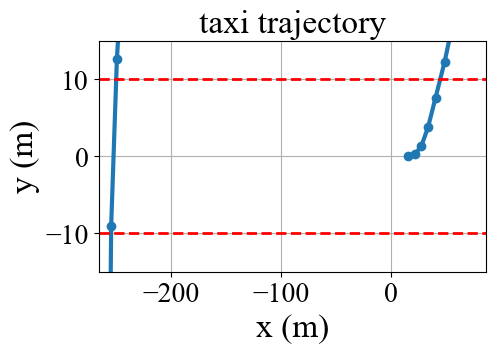

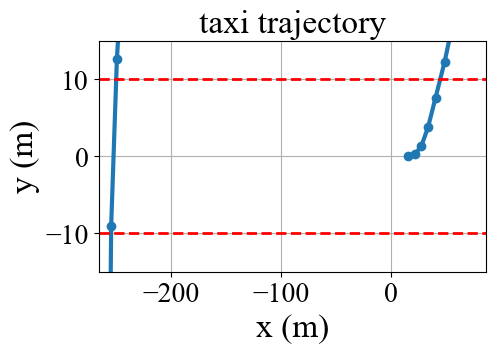

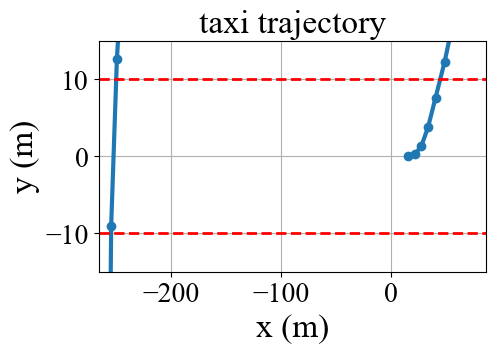

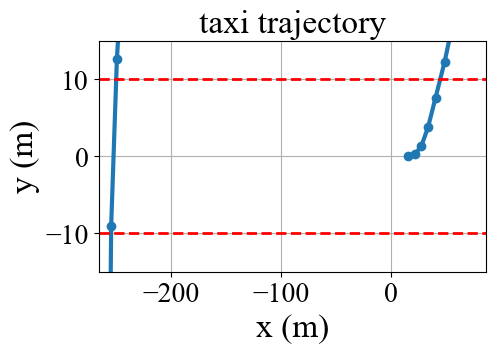

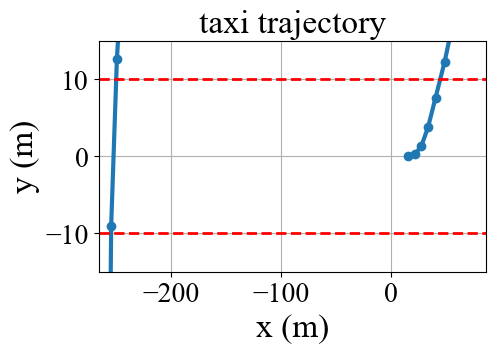

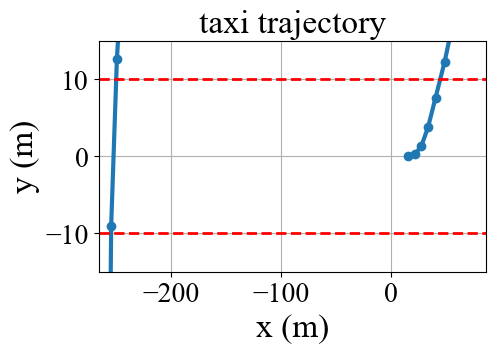

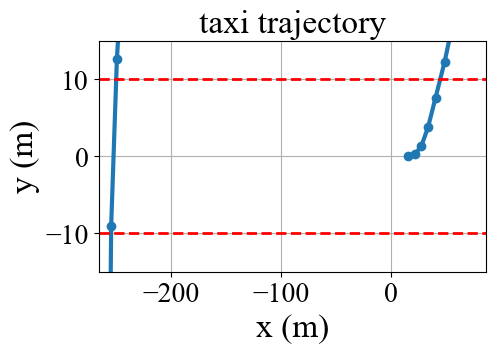

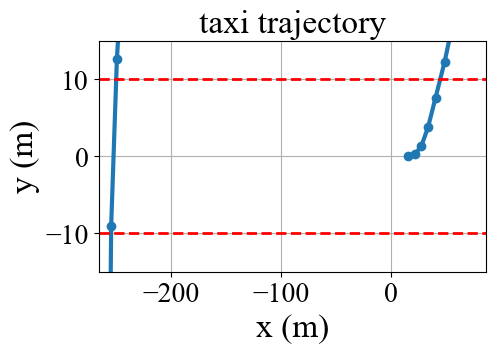

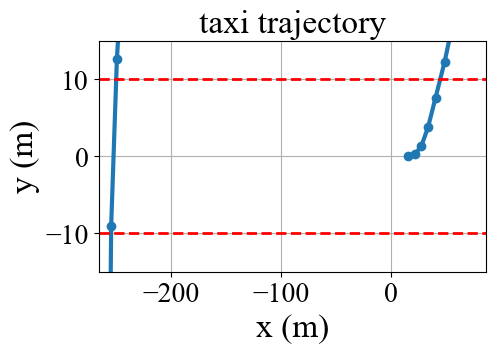

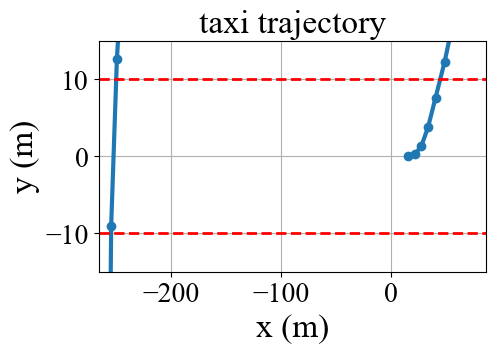

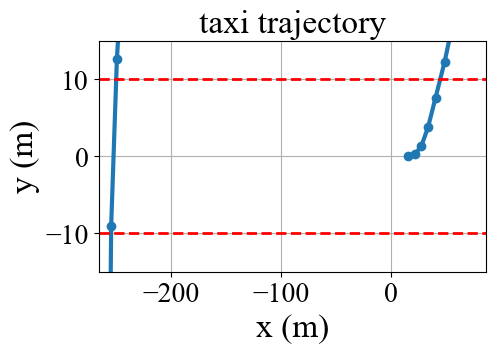

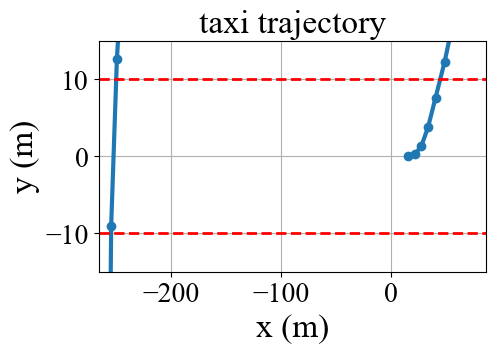

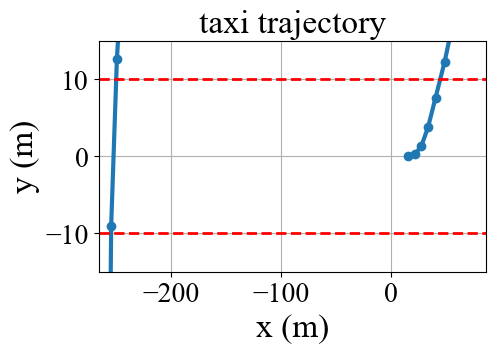

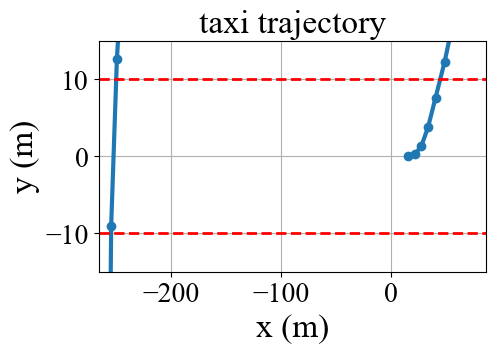

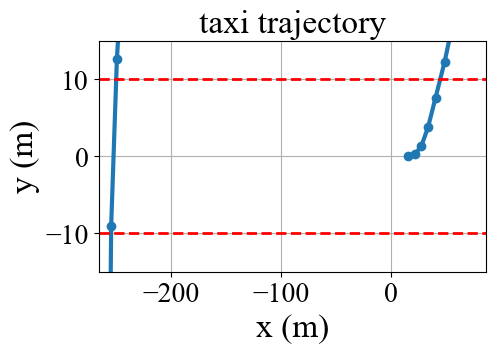

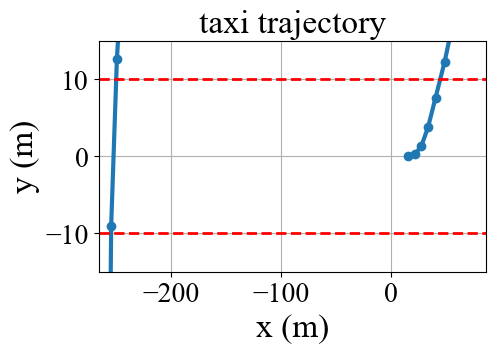

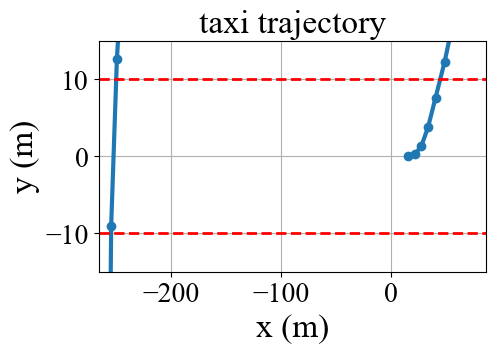

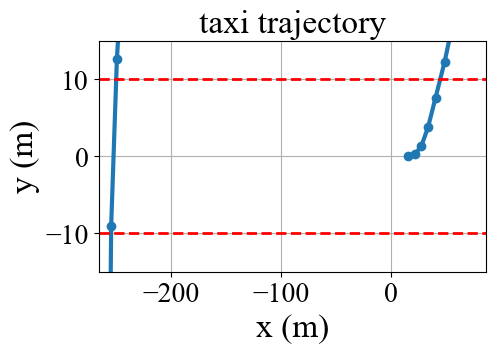

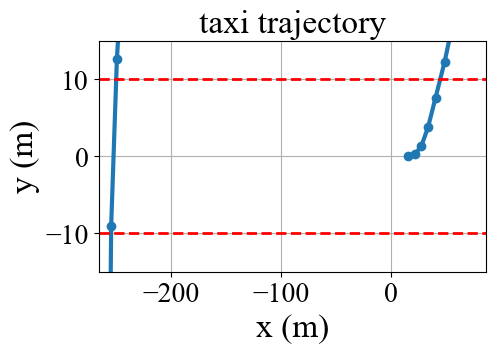

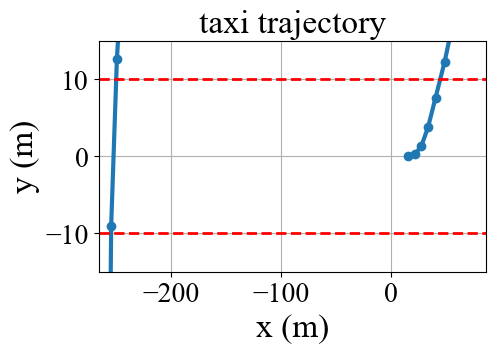

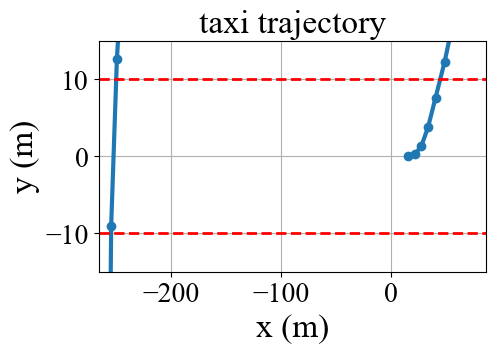

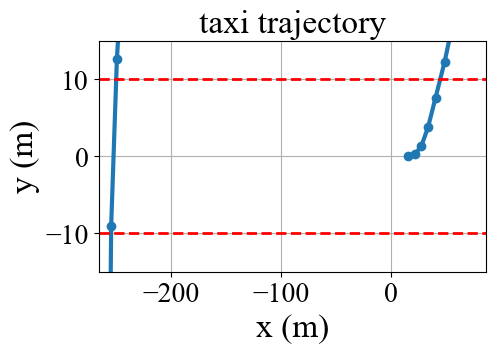

In [107]:
ctes = df.loc[episodes[episode_num], "distance_to_centerline_meters"]
dps = df.loc[episodes[episode_num], "downtrack_position_meters"]
dp_min = np.min(dps) - 10
dp_max = np.max(dps) + 10
dps_constraints = np.linspace(dp_min, dp_max)
constraint = 10

for i in episodes[episode_num]:
    plt.figure(figsize=(5,3))
    ax = plt.gca()
    ax.plot(dps[:i+1], ctes[:i+1],"-o", lw=3)
    ax.grid()
    ax.set_ylim(-15,15)
    ax.set_xlim(dp_min, dp_max)
    ax.plot(dps_constraints, np.ones(len(dps_constraints)) * constraint, "r--", lw=2)
    ax.plot(dps_constraints, -1 * np.ones(len(dps_constraints)) * constraint, "r--", lw=2)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_title("taxi trajectory")
